In [1]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
from arch.unitroot import ADF
import yfinance as yf

trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
threshold = 1.96

def adfTest(series):
    adfT = ADF(series)
    if adfT.pvalue > 0.05:
        return False, adfT.pvalue
    return True, adfT.pvalue

def visualize(data, symbols):
    plt.figure(figsize=(15, 7))
    for syl in symbols:
        data[syl].plot(label=syl)
    plt.legend()
    plt.ylabel('Adjusted YTM')
    plt.show()
    print("Successfully Plot YTM")

def spread(X, Y):
    spread = Y - X
    if not adfTest(spread)[0]:
        print("Spread is not stationary. P value of ADF test is", adfTest(spread)[1])
    else:
        print('''
            Spread is stationary
            P value of ADF test: %f
            ''' % (adfTest(spread)[1]))

def cointegration(X, Y):
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    resid = results.resid
    if not adfTest(resid)[0]:
        print("X and Y are not cointegrated. P value of ADF test is", adfTest(resid)[1])
        return None
    else:
        print('''
        X and Y are cointegrated
        P value of ADF test: %f
        Intercept: %f
        Beta: %f
        ''' % (adfTest(resid)[1], results.params[0], results.params[1]))
        return results.params[0], results.params[1]

def kalman_filter(data, symbols, trans_cov):
    obs_mat = sm.add_constant(data[symbols[0]].values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=np.ones(2),
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=0.5,
                      transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(data[symbols[1]].values)
    slope=state_means[:, 0]
    intercept=state_means[:, 1]
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index, slope, c='b')
    plt.ylabel('slope')
    plt.title('kf updating slope')
    
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index,intercept,c='r')
    plt.ylabel('intercept')
    plt.title('kf updating intercept')
    plt.show()

    kl_spread = data[symbols[1]] - data[symbols[0]] * state_means[:, 0] - state_means[:, 1]
    return kl_spread

def set_signal(data, threshold, symbols):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    df = pd.DataFrame()
    count = 0
    titles = ["Fixed Beta", "Kalman Filter"]

    for sym in symbols:
        mean, lower, upper, buy, sell, close_pos = "mean_"+sym, "lower_"+sym, "upper_"+sym, "buy_"+sym, "sell_"+sym, "close_pos_"+sym

        df['spread'] = data[sym]
        df[mean] = df['spread'].mean()
        mu = df[mean]
        sigma = df['spread'].std()
        df[upper] = mu + threshold * sigma
        df[lower] = mu - threshold * sigma

        df[buy] = df['spread'][((df['spread'] < df[lower]) & (df['spread'].shift(1) >= df[lower])) | 
                                ((df['spread'] < df[upper]) & (df['spread'].shift(1) >= df[upper]))]
        # df[close_pos] = df['spread'][((df['spread'] > lower) & (df['spread'].shift(1) <= lower)) | 
        #                             ((df['spread'] < upper) & (df['spread'].shift(1) >= upper))]
        df[sell] = df['spread'][((df['spread'] > df[upper]) & (df['spread'].shift(1) <= df[upper])) |
                                ((df['spread'] > df[lower]) & (df['spread'].shift(1) <= df[lower]))]

        pic = ax[count]
        pic.plot(df['spread'], 'g')
        pic.plot(df[mean],'--r', label=mean)
        pic.plot(df[upper], '--b', label=upper)
        pic.plot(df[lower], '--b', label=lower)
        pic.plot(df[buy], 'm^', label=buy)
        pic.plot(df[sell], 'cv', label=sell)

        pic.set_title(titles[count])
        pic.set_xlabel('Time')
        pic.set_ylabel('YTM' + titles[count])
        pic.legend()

        count+=1

    return df
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    

    print("Success!")

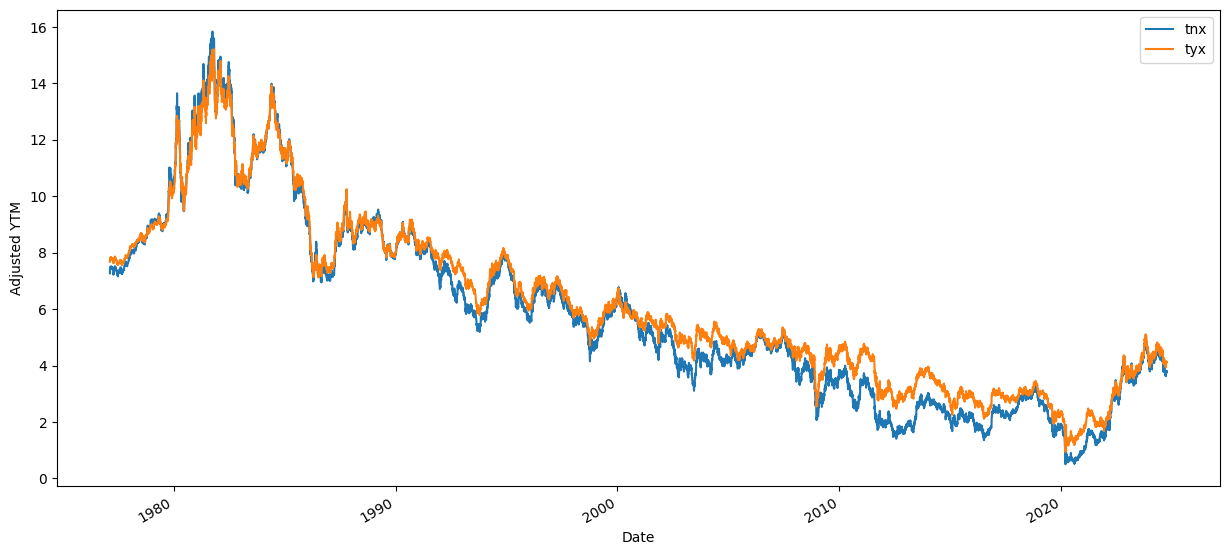

Successfully Plot YTM


In [4]:
tnx = yf.Ticker("^TNX")
tyx = yf.Ticker("^TYX")
hist = pd.DataFrame()

hist['tnx'] = pd.DataFrame(tnx.history(period="max")['Close'])
hist['tyx'] = pd.DataFrame(tyx.history(period="max")['Close'])
hist.dropna(axis = 0, inplace = True)

syms = ['tnx', 'tyx']
visualize(hist, syms)


In [7]:
spread(hist['tnx'], hist['tyx'])

Spread is not stationary. P value of ADF test is 0.05535038939038004


In [9]:
params = cointegration(hist['tnx'], hist['tyx'])
intercept = 0
beta = 0
if params is not None:
    intercept = params[0]
    beta = params[1]
res = pd.DataFrame()
coin_spread = hist['tyx'] - intercept - beta*hist['tnx']


        X and Y are cointegrated
        P value of ADF test: 0.006948
        Intercept: 0.899247
        Beta: 0.909912
        


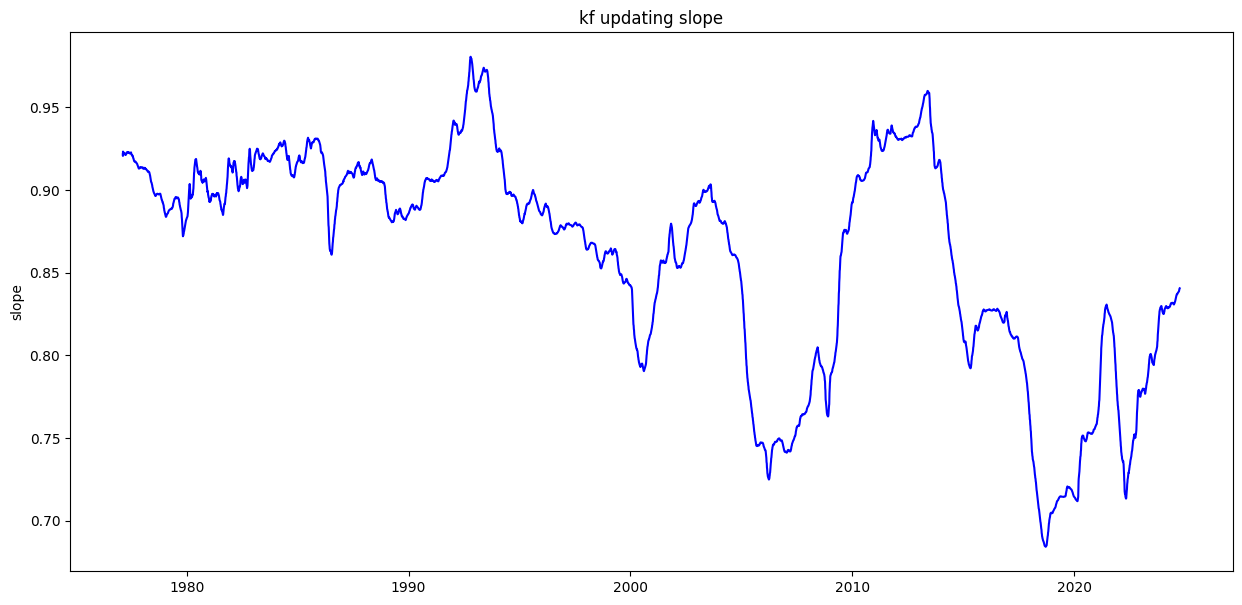

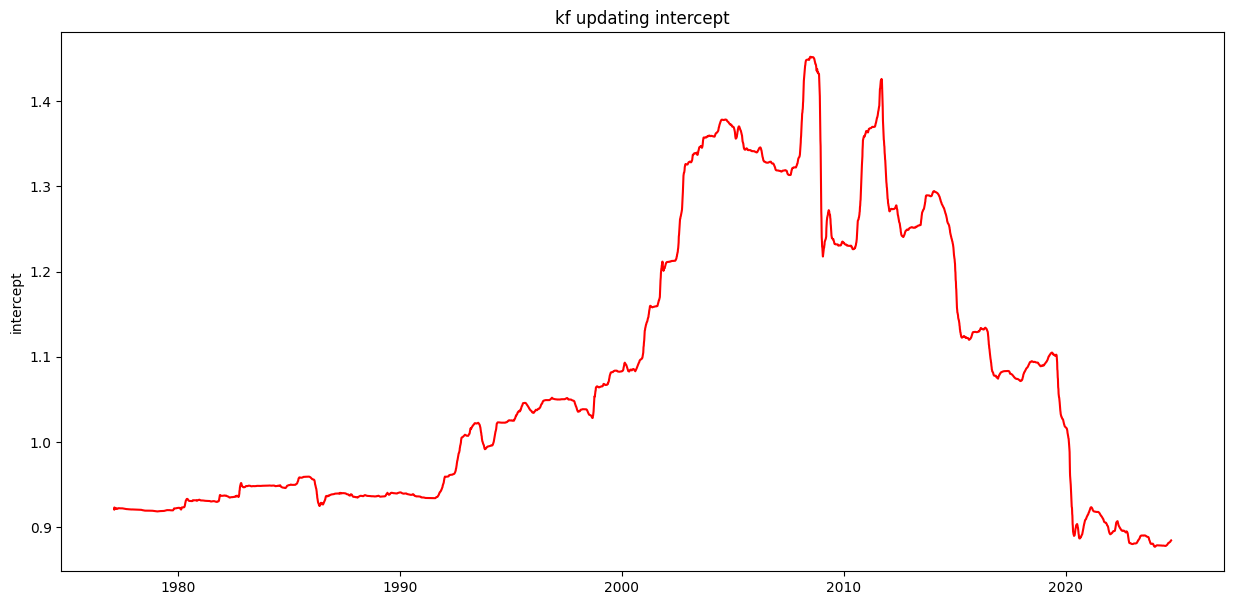

In [11]:
kf_spread = kalman_filter(hist, syms, trans_cov)

In [13]:
result = adfTest(kf_spread)
print(result)

(True, 1.8647814862870957e-19)


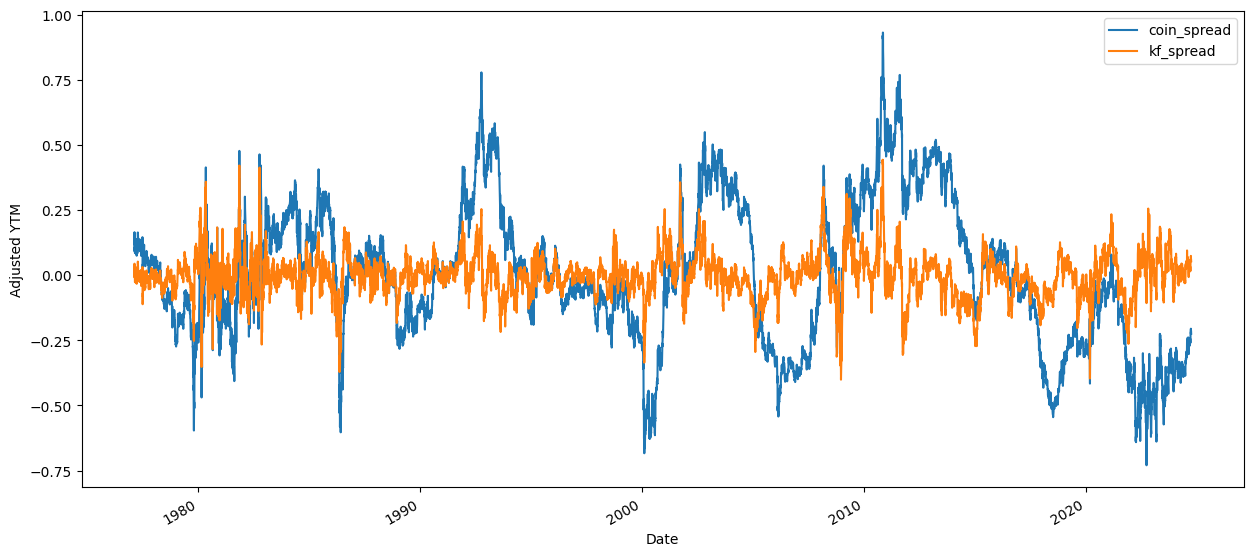

Successfully Plot YTM


In [15]:
res['coin_spread'], res['kf_spread'] = coin_spread, kf_spread
spread_syms = ["coin_spread", "kf_spread"]
visualize(res, spread_syms)

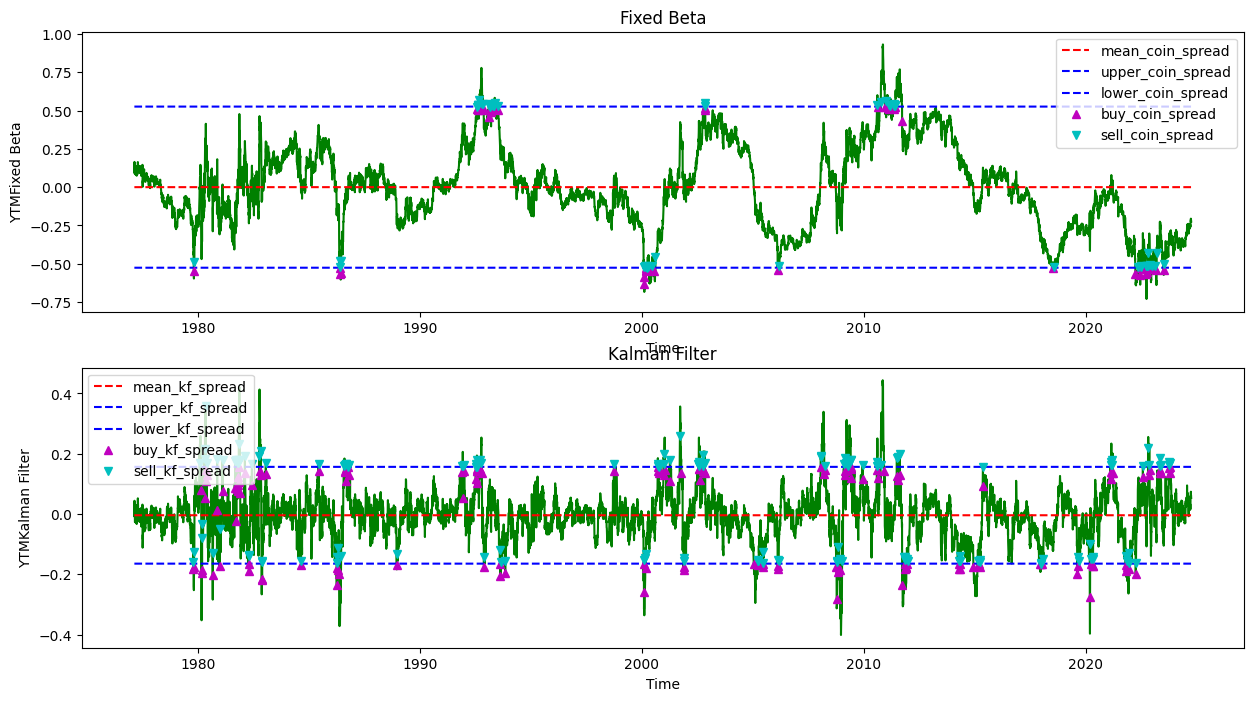

In [165]:
df = set_signal(res, threshold, spread_syms)

In [166]:
df = df.fillna(1000)
df.head()

,spread,mean_coin_spread,upper_coin_spread,lower_coin_spread,buy_coin_spread,sell_coin_spread,mean_kf_spread,upper_kf_spread,lower_kf_spread,buy_kf_spread,sell_kf_spread
Date,,,,,,,,,,,
1977-02-15 00:00:00-06:00,-0.004688,2.335721e-15,0.525762,-0.525762,1000.0,1000.0,-0.004109,0.156382,-0.1646,1000.0,1000.0
1977-02-16 00:00:00-06:00,-0.008172,2.335721e-15,0.525762,-0.525762,1000.0,1000.0,-0.004109,0.156382,-0.1646,1000.0,1000.0
1977-02-17 00:00:00-06:00,0.043979,2.335721e-15,0.525762,-0.525762,1000.0,1000.0,-0.004109,0.156382,-0.1646,1000.0,1000.0
1977-02-18 00:00:00-06:00,-0.003360,2.335721e-15,0.525762,-0.525762,1000.0,1000.0,-0.004109,0.156382,-0.1646,1000.0,1000.0
1977-02-22 00:00:00-06:00,-0.002063,2.335721e-15,0.525762,-0.525762,1000.0,1000.0,-0.004109,0.156382,-0.1646,1000.0,1000.0


# Spread Cointegration Type of Signals

In [167]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (30y) and short the cheap (10y)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (30y) and long the cheap (10y)
NAA = 1000.0
coin_spread_signals = df[["buy_coin_spread", "sell_coin_spread"]]
cs_30 = np.zeros(len(coin_spread_signals))
# cs_sell_30 = np.zeros(len(coin_spread_signals))
# cs_buy_10 = np.zeros(len(coin_spread_signals))
# cs_sell_10 = np.zeros(len(coin_spread_signals))
for t in coin_spread_signals.index:
    b = df.loc[t]["buy_coin_spread"]
    s = df.loc[t]["sell_coin_spread"]
    if (b != NAA) & (s == NAA):
        cs_30[list(coin_spread_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        cs_30[list(coin_spread_signals.index).index(t)] = -1
cs_10 = cs_30 * (-1)

In [168]:
coin_spread_signals['cs_30'] = cs_30
coin_spread_signals['cs_10'] = cs_10

In [173]:
coin_spread_signals[coin_spread_signals["cs_30"] != 0]

,buy_coin_spread,sell_coin_spread,cs_30,cs_10
Date,,,,
1979-10-19 00:00:00-05:00,-0.547107,1000.000000,1.0,-1.0
1979-10-26 00:00:00-05:00,1000.000000,-0.488007,-1.0,1.0
1986-05-16 00:00:00-05:00,-0.529443,1000.000000,1.0,-1.0
1986-05-19 00:00:00-05:00,1000.000000,-0.480344,-1.0,1.0
1986-05-22 00:00:00-05:00,-0.569353,1000.000000,1.0,-1.0
...,...,...,...,...
2023-02-08 00:00:00-06:00,1000.000000,-0.513155,-1.0,1.0
2023-02-22 00:00:00-06:00,-0.540831,1000.000000,1.0,-1.0
2023-03-13 00:00:00-05:00,1000.000000,-0.431588,-1.0,1.0


In [175]:
coin_spread_signals['raw_30'] = hist['tyx']
coin_spread_signals['raw_10'] = hist['tnx']
coin_spread_signals

,buy_coin_spread,sell_coin_spread,cs_30,cs_10,raw_30,raw_10
Date,,,,,,
1977-02-15 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.700,7.360
1977-02-16 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.340
1977-02-17 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.260
1977-02-18 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.760,7.410
1977-02-22 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.770,7.420
...,...,...,...,...,...,...
2024-09-24 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.089,3.736
2024-09-25 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.134,3.781
2024-09-26 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.124,3.791


In [159]:
hist['tnx']

Date
1977-02-15 00:00:00-06:00    7.360
1977-02-16 00:00:00-06:00    7.340
1977-02-17 00:00:00-06:00    7.260
1977-02-18 00:00:00-06:00    7.410
1977-02-22 00:00:00-06:00    7.420
                             ...  
2024-09-24 00:00:00-05:00    3.736
2024-09-25 00:00:00-05:00    3.781
2024-09-26 00:00:00-05:00    3.791
2024-09-27 00:00:00-05:00    3.749
2024-09-30 00:00:00-05:00    3.802
Name: tnx, Length: 11931, dtype: float64

In [ ]:
def bond_price(face_value, coupon_rate, yield_to_maturity, years_to_maturity, payments_per_year=2):
    # Calculate the coupon payment per period
    coupon_payment = (face_value * coupon_rate) / payments_per_year
    
    # Calculate the total number of payments
    total_periods = years_to_maturity * payments_per_year
    
    # Calculate the yield per period
    period_yield = yield_to_maturity / payments_per_year
    
    # Calculate the present value of the coupon payments
    coupon_pv = sum([coupon_payment / (1 + period_yield) ** t for t in range(1, total_periods + 1)])
    
    # Calculate the present value of the face value
    face_value_pv = face_value / (1 + period_yield) ** total_periods
    
    # Calculate the total bond price
    bond_price = coupon_pv + face_value_pv
    
    return bond_price

# Example values
face_value = 1000  # Face value of the bond
coupon_rate = 0.02  # 2% coupon rate
yield_to_maturity = 0.03802  # 3.802% yield (from ^TNX)
years_to_maturity = 10  # 10 years to maturity

price = bond_price(face_value, coupon_rate, yield_to_maturity, years_to_maturity)
print(f"The bond price is: ${price:.2f}")


# Kalman Filter Version of Signals

In [183]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (30y) and short the cheap (10y)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (30y) and long the cheap (10y)
NAA = 1000.0
kf_signals = df[["buy_kf_spread", "sell_kf_spread"]]
cs_30_kf = np.zeros(len(kf_signals))
# cs_sell_30 = np.zeros(len(coin_spread_signals))
# cs_buy_10 = np.zeros(len(coin_spread_signals))
# cs_sell_10 = np.zeros(len(coin_spread_signals))
for t in kf_signals.index:
    b = df.loc[t]["buy_kf_spread"]
    s = df.loc[t]["sell_kf_spread"]
    if (b != NAA) & (s == NAA):
        cs_30_kf[list(kf_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        cs_30_kf[list(kf_signals.index).index(t)] = -1
cs_10_kf = cs_30_kf * (-1)
kf_signals['cs_30_kf'] = cs_30_kf
kf_signals['cs_10_kf'] = cs_10_kf
kf_signals['raw_30_kf'] = hist['tyx']
kf_signals['raw_10_kf'] = hist['tnx']
kf_signals

,buy_kf_spread,sell_kf_spread,cs_30_kf,cs_10_kf,raw_30_kf,raw_10_kf
Date,,,,,,
1977-02-15 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.700,7.360
1977-02-16 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.340
1977-02-17 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.260
1977-02-18 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.760,7.410
1977-02-22 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.770,7.420
...,...,...,...,...,...,...
2024-09-24 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.089,3.736
2024-09-25 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.134,3.781
2024-09-26 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.124,3.791


In [187]:
coin_spread_signals.to_csv("cs_signals.csv", index=False)
kf_signals.to_csv("kf_signals.csv", index=False)